In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import tqdm
import copy
import gc
import sys
import os
import f90nml
import itertools

import bokeh
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource, CDSView, GroupFilter, HoverTool
from bokeh.plotting import figure, show
from bokeh.transform import factor_cmap
from bokeh.palettes import Spectral11

from bokeh.models.mappers import CategoricalColorMapper

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import scipy as sp
from scipy.sparse import linalg

import importlib

import analysis_functions

In [2]:
dataDir='.'
simDataDir='/'.join([dataDir,'test_multiReplica_MD_table'])
simDataFilename='interrior_data_table.csv'
simDataFilePath='/'.join([simDataDir,simDataFilename])
simData=pd.read_csv(simDataFilePath)
simData.head()

,Window,Rep,Time,Rst07_Z,Rst08_Z,X_Index
0,1,1,0,114.462,3.867,1
1,1,1,500,114.163,4.161,1
2,1,1,1000,113.875,4.452,1
3,1,1,1500,114.027,4.310,1
4,1,1,2000,113.790,4.512,1


In [3]:
print(simData.X_Index.unique(),
      '\n',
      simData.Window.unique())
maxWin=simData['Window'].max()
minWin=simData['Window'].min()
simData['X_Index']=simData['X_Index'].map(
        lambda x: np.clip(x,minWin,maxWin)-minWin)
simData['Window']=simData['Window']-minWin
print('--- --- ---')
print(simData.X_Index.unique(),
      '\n',
      simData.Window.unique())

[ 1  2  0  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57] 
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56]
--- --- ---
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55] 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55]


In [4]:
testWin=0
testRep=1
tempDat=simData[(simData['Window']==testWin) & \
        (simData['Rep']==testRep)]
tempDat.head()

,Window,Rep,Time,Rst07_Z,Rst08_Z,X_Index
0,0,1,0,114.462,3.867,0
1,0,1,500,114.163,4.161,0
2,0,1,1000,113.875,4.452,0
3,0,1,1500,114.027,4.310,0
4,0,1,2000,113.790,4.512,0


In [23]:
tempCols=[]
tempCols.append('Window')
tempCols.append(None)

KeyError: '[None] not in index'

In [ ]:
importlib.reload(analysis_functions)
analysis_functions.compute_bin_escape_counts(
    testWin,tempDat['X_Index'],
)

In [ ]:
importlib.reload(analysis_functions)
simGroups=simData.groupby(['Window','Rep'])

for simGroup in simGroups:
    groupWin,groupRep=simGroup[0]
    print('groupWin:',groupWin,'; groupRep:',groupRep,
          '\n\tescapeData:',
          analysis_functions.compute_bin_escape_counts(
              groupWin,simGroup[1]['X_Index']),
          '\n--- --- ---')

In [20]:
importlib.reload(analysis_functions)

winGroups=simData.groupby(['Window'])

binSet=np.sort(np.unique(np.concatenate([
    simData['Window'].unique(),
    simData['X_Index'].unique()
])))
nBins=len(binSet)
binMap={}
for iBin,binName in enumerate(binSet):
    binMap[binName]=iBin

escapeMat=sp.sparse.lil_matrix((nBins,nBins))
countArray=np.zeros(nBins,dtype=int)

for winGroup in winGroups:
    groupWin=winGroup[0]
    iWin=binMap[groupWin]
    print('Window:',groupWin)
    repGroups=winGroup[1].groupby(['Rep'])
    print('---')
    for repGroup in repGroups:
        groupRep=repGroup[0]
        print('Rep:',groupRep)
        repEscapeData=analysis_functions.compute_bin_escape_counts(
                      groupWin,repGroup[1]['X_Index'],
                      binSet=binSet,
                      giveBinVec=True,
                      giveDeltaVal=True,
                      giveBinT=True)
        print('\tescapeData:',
              repEscapeData,
              '\n---')
        countArray[iWin]+=repEscapeData['count']
        for escapeBinName,escapeCount in \
            zip(repEscapeData['escapes'][0],
                repEscapeData['escapes'][1]):
            iEscapeBin=binMap[escapeBinName]
            escapeMat[iWin,iEscapeBin]+=escapeCount
    escapeMat[iWin,:]=escapeMat[iWin,:]/countArray[iWin]
    escapeMat[iWin,iWin]=1-np.sum(escapeMat[iWin,:])
    print('--- --- ---')

escapeMat=escapeMat.tocsr()
print('countArray:',countArray)
print('escapeMat:',escapeMat)


Window: 0
---
Rep: 1
	escapeData: {'count': 14912, 'escapes': (array([1]), array([434])), 'binVec': array([1, 1, 1, ..., 1, 1, 1]), 'binT': array([0, 0, 0, ..., 0, 0, 0]), 'deltaVal': 1} 
---
--- --- ---
Window: 1
---
Rep: 1
	escapeData: {'count': 12850, 'escapes': (array([0, 2]), array([284, 416])), 'binVec': array([0, 2, 2, ..., 2, 2, 2]), 'binT': array([0, 0, 3, ..., 0, 0, 0]), 'deltaVal': 1} 
---
Rep: 2
	escapeData: {'count': 12844, 'escapes': (array([0, 2]), array([256, 408])), 'binVec': array([0, 0, 2, ..., 2, 2, 2]), 'binT': array([0, 0, 0, ..., 0, 0, 0]), 'deltaVal': 1} 
---
Rep: 3
	escapeData: {'count': 14819, 'escapes': (array([0, 2]), array([327, 555])), 'binVec': array([0, 0, 2, ..., 2, 2, 2]), 'binT': array([0, 0, 3, ..., 0, 0, 0]), 'deltaVal': 1} 
---
Rep: 4
	escapeData: {'count': 12869, 'escapes': (array([0, 2]), array([315, 362])), 'binVec': array([0, 2, 2, ..., 2, 1, 2]), 'binT': array([0, 0, 0, ..., 0, 1, 0]), 'deltaVal': 1} 
---
Rep: 5
	escapeData: {'count': 8924, 'e

Rep: 1
	escapeData: {'count': 39365, 'escapes': (array([23, 25]), array([1360, 1152])), 'binVec': array([ 1, 25, 25, ..., 25, 25, 25]), 'binT': array([0, 0, 0, ..., 0, 0, 0]), 'deltaVal': 1} 
---
--- --- ---
Window: 25
---
Rep: 1
	escapeData: {'count': 17346, 'escapes': (array([24, 26]), array([1525,  157])), 'binVec': array([ 1, 26, 26, ..., 26, 26, 26]), 'binT': array([0, 0, 0, ..., 0, 0, 0]), 'deltaVal': 1} 
---
Rep: 2
	escapeData: {'count': 12913, 'escapes': (array([24, 26]), array([418,  54])), 'binVec': array([ 1, 26, 26, ..., 26, 26, 26]), 'binT': array([0, 0, 0, ..., 0, 0, 0]), 'deltaVal': 1} 
---
Rep: 3
	escapeData: {'count': 17788, 'escapes': (array([24, 26]), array([348, 414])), 'binVec': array([ 1, 26, 26, ..., 26, 26, 26]), 'binT': array([0, 0, 0, ..., 0, 0, 0]), 'deltaVal': 1} 
---
Rep: 4
	escapeData: {'count': 12656, 'escapes': (array([24, 26]), array([483, 465])), 'binVec': array([ 0, 26, 26, ..., 26, 26, 26]), 'binT': array([0, 0, 0, ..., 0, 0, 0]), 'deltaVal': 1} 
---

In [16]:
import seaborn as sns
import networkx as nwx

In [ ]:
plt.figure(figsize=(12,12))
escapeNet=nwx.from_scipy_sparse_matrix(escapeMat)
edgeWeights=[-np.log(escapeNet.get_edge_data(*edgeTuple)['weight']) for edgeTuple in list(escapeNet.edges)]
nwx.draw_networkx(escapeNet,with_labels=True,
                  edge_color=edgeWeights,
                  width=8)
plt.show()

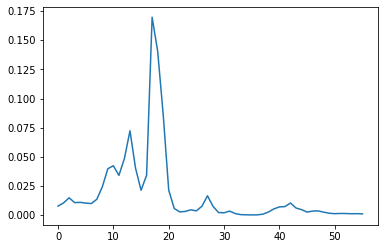

array([0.00792609, 0.01063189, 0.01499295, 0.01087963, 0.01110518,
       0.01047639, 0.01006131, 0.01371619, 0.02436673, 0.03994042,
       0.04245106, 0.03420104, 0.04887149, 0.0724319 , 0.0404929 ,
       0.02147933, 0.03431469, 0.16973767, 0.14073008, 0.08650911,
       0.02157374, 0.00583361, 0.00291758, 0.00334786, 0.00470758,
       0.00383332, 0.00777511, 0.0167279 , 0.00776236, 0.00239321,
       0.00213933, 0.00361457, 0.00151375, 0.00059213, 0.00045018,
       0.00034259, 0.0003964 , 0.00095784, 0.00276862, 0.00548726,
       0.00719951, 0.00747012, 0.01055295, 0.00626554, 0.00485859,
       0.00276046, 0.00362344, 0.00378118, 0.00270792, 0.00178114,
       0.00141669, 0.00158763, 0.00153221, 0.00135933, 0.00142134,
       0.00123097])

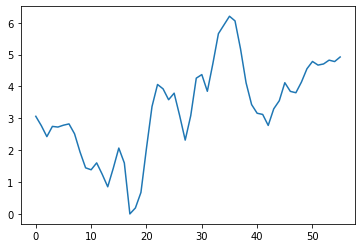

In [21]:
escapeEig=np.linalg.eig(escapeMat.todense().T)
si=np.argsort(1-escapeEig[0])
piVec=np.array(escapeEig[1])[:,si[0]]
piVec=piVec/np.sum(piVec)
plt.plot(piVec)
plt.show()
testVec=-np.log(piVec)
testVec=testVec-np.min(testVec)
plt.plot(testVec)
piVec

In [38]:
importlib.reload(analysis_functions)

escapeDataDict=analysis_functions.analyze_indexed_milestoning_escapes(
    milestoneData=simData,windowColumn='Window',xIndexColumn='X_Index',
    repColumn='Rep',groupingColumn=None,
    giveEscapeMats=True,giveCounts=True,
    giveBins=True,giveBinMaps=True)
escapeDataDict

Group: 0
	Window: 0 (iWin =  0 )
		Rep: 1
		count: 14912 escapes: (array([1]), array([434]))
		---
	--- ---
	Window: 1 (iWin =  1 )
		Rep: 1
		count: 12850 escapes: (array([0, 2]), array([284, 416]))
		---
		Rep: 2
		count: 12844 escapes: (array([0, 2]), array([256, 408]))
		---
		Rep: 3
		count: 14819 escapes: (array([0, 2]), array([327, 555]))
		---
		Rep: 4
		count: 12869 escapes: (array([0, 2]), array([315, 362]))
		---
		Rep: 5
		count: 8924 escapes: (array([0, 2]), array([181, 314]))
		---
		Rep: 6
		count: 3957 escapes: (array([0, 2]), array([ 98, 108]))
		---
		Rep: 7
		count: 14992 escapes: (array([0, 2]), array([302, 800]))
		---
	--- ---
	Window: 2 (iWin =  2 )
		Rep: 1
		count: 24750 escapes: (array([1, 3]), array([640, 492]))
		---
	--- ---
	Window: 3 (iWin =  3 )
		Rep: 1
		count: 4928 escapes: (array([2, 4]), array([135, 136]))
		---
	--- ---
	Window: 4 (iWin =  4 )
		Rep: 1
		count: 24707 escapes: (array([3, 5]), array([668, 633]))
		---
	--- ---
	Window: 5 (iWin =  5 )

	Window: 47 (iWin =  47 )
		Rep: 1
		count: 18774 escapes: (array([46, 48]), array([581, 460]))
		---
	--- ---
	Window: 48 (iWin =  48 )
		Rep: 1
		count: 28644 escapes: (array([47, 49]), array([980, 620]))
		---
	--- ---
	Window: 49 (iWin =  49 )
		Rep: 1
		count: 13857 escapes: (array([48, 50]), array([456, 323]))
		---
	--- ---
	Window: 50 (iWin =  50 )
		Rep: 1
		count: 8906 escapes: (array([49, 51]), array([261, 262]))
		---
	--- ---
	Window: 51 (iWin =  51 )
		Rep: 1
		count: 8914 escapes: (array([50, 52]), array([234, 244]))
		---
	--- ---
	Window: 52 (iWin =  52 )
		Rep: 1
		count: 7918 escapes: (array([51, 53]), array([235, 223]))
		---
		Rep: 2
		count: 7936 escapes: (array([51, 53]), array([217, 198]))
		---
		Rep: 3
		count: 7929 escapes: (array([51, 53]), array([229, 208]))
		---
		Rep: 4
		count: 7926 escapes: (array([51, 53]), array([201, 224]))
		---
		Rep: 5
		count: 7941 escapes: (array([51, 53]), array([259, 209]))
		---
		Rep: 6
		count: 2970 escapes: (array([51, 53

{0: {'bins': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
         34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
         51, 52, 53, 54, 55]),
  'binMap': {0: 0,
   1: 1,
   2: 2,
   3: 3,
   4: 4,
   5: 5,
   6: 6,
   7: 7,
   8: 8,
   9: 9,
   10: 10,
   11: 11,
   12: 12,
   13: 13,
   14: 14,
   15: 15,
   16: 16,
   17: 17,
   18: 18,
   19: 19,
   20: 20,
   21: 21,
   22: 22,
   23: 23,
   24: 24,
   25: 25,
   26: 26,
   27: 27,
   28: 28,
   29: 29,
   30: 30,
   31: 31,
   32: 32,
   33: 33,
   34: 34,
   35: 35,
   36: 36,
   37: 37,
   38: 38,
   39: 39,
   40: 40,
   41: 41,
   42: 42,
   43: 43,
   44: 44,
   45: 45,
   46: 46,
   47: 47,
   48: 48,
   49: 49,
   50: 50,
   51: 51,
   52: 52,
   53: 53,
   54: 54,
   55: 55},
  'escapeMatrix': <56x56 sparse matrix of type '<class 'numpy.float64'>'
  	with 166 stored elements in LInked List form

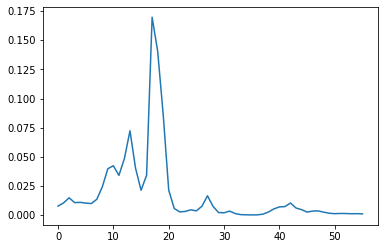

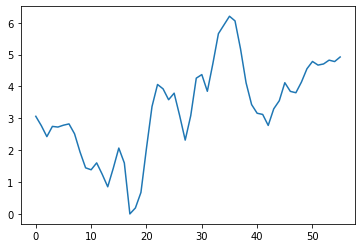

In [42]:
escapeDataDict[0]['piVector']
plt.plot(escapeDataDict[0]['piVector'])
plt.show()
tempVec=-np.log(escapeDataDict[0]['piVector'])
tempVec=tempVec-np.min(tempVec)
plt.plot(tempVec)
plt.show()